In [32]:
import pandas as pd
import numpy as np

import seaborn as sns
import plotly.express as px
from matplotlib import pyplot as plt 
%matplotlib inline

from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import warnings
warnings.filterwarnings('ignore') 

from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag, pos_tag_sents
from nltk.corpus import wordnet

# Exploration

In [33]:
# Load the data

df = pd.read_csv('asos-reviews-with-rating.csv')

In [34]:
df.head()

,Unnamed: 0,date,review,rating
0,0,2020-12-09,Cristy was amazing ...,5 stars: Excellent
1,1,2020-12-09,Unhappy customer ...,1 star: Bad
2,2,2020-12-09,Still Waiting P...,2 stars: Poor
3,3,2020-12-09,Great after sales support ...,5 stars: Excellent
4,4,2020-12-09,Michael was very polite and helpful… ...,5 stars: Excellent


In [35]:
# Drop columns 'Unnamed: 0'

df = df.drop(['Unnamed: 0'], axis = 1)

In [36]:
df.shape

(20000, 3)

In [37]:
df.dtypes

date      object
review    object
rating    object
dtype: object

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    20000 non-null  object
 1   review  20000 non-null  object
 2   rating  20000 non-null  object
dtypes: object(3)
memory usage: 468.9+ KB


In [39]:
df.nunique() 

date        321
review    19446
rating        5
dtype: int64

In [40]:
df.head()

,date,review,rating
0,2020-12-09,Cristy was amazing ...,5 stars: Excellent
1,2020-12-09,Unhappy customer ...,1 star: Bad
2,2020-12-09,Still Waiting P...,2 stars: Poor
3,2020-12-09,Great after sales support ...,5 stars: Excellent
4,2020-12-09,Michael was very polite and helpful… ...,5 stars: Excellent


In [41]:
# Checking for duplicates in 'review'

df['review'].value_counts().head(10)  

Very helpful                  101
Great service                  32
very helpful                   27
Great customer service         25
Very helpful!                  17
Great customer service!        14
Excellent customer service     14
Really helpful                 11
Good service                   11
great service                  10
Name: review, dtype: int64

In [42]:
# Seems to be from different customers. 
# Will later make a decision for whether its relevant to keep all of these or not

df[(df.review == 'Very helpful')]

,date,review,rating
269,2020-12-07,Very helpful,5 stars: Excellent
366,2020-12-06,Very helpful,5 stars: Excellent
954,2020-12-01,Very helpful,5 stars: Excellent
1128,2020-11-30,Very helpful,5 stars: Excellent
1509,2020-11-26,Very helpful,5 stars: Excellent
...,...,...,...
19389,2020-01-28,Very helpful,5 stars: Excellent
19549,2020-01-27,Very helpful,5 stars: Excellent
19690,2020-01-26,Very helpful,5 stars: Excellent
19714,2020-01-26,Very helpful,5 stars: Excellent


In [43]:
# Create new column for number of stars. This will be used as the target variable.

df['stars'] = df['rating'].apply(lambda x: x.split(' ')[0].split()[0])

In [44]:
df

,date,review,rating,stars
0,2020-12-09,Cristy was amazing ...,5 stars: Excellent,5
1,2020-12-09,Unhappy customer ...,1 star: Bad,1
2,2020-12-09,Still Waiting P...,2 stars: Poor,2
3,2020-12-09,Great after sales support ...,5 stars: Excellent,5
4,2020-12-09,Michael was very polite and helpful… ...,5 stars: Excellent,5
...,...,...,...,...
19995,2020-01-24,Very short waiting time ...,5 stars: Excellent,5
19996,2020-01-24,great Suzanne w...,5 stars: Excellent,5
19997,2020-01-24,Qasim was amazing and genuine ...,5 stars: Excellent,5
19998,2020-01-24,Excellent customer service ...,5 stars: Excellent,5


In [45]:
# Checking the value counts of 'stars'

df['stars'].value_counts()

5    13403
1     4843
4      905
2      501
3      348
Name: stars, dtype: int64

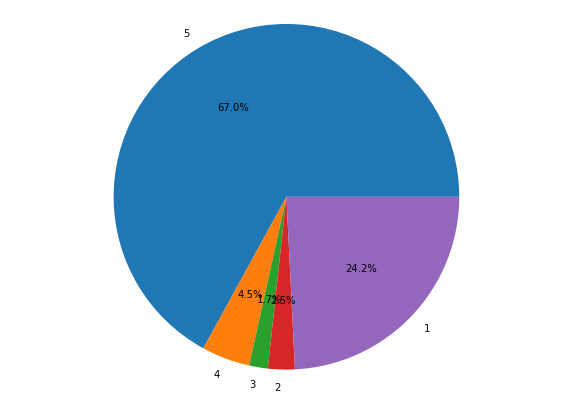

In [46]:
# Most people have rated 5 stars
# People seem either 'happy' or 'unhappy'

plt.figure(figsize =(10, 7)) 
plt.pie([13403, 905, 348, 501, 4843], labels = ['5', '4', '3', '2', '1'], autopct='%1.1f%%');
plt.axis('equal')
plt.show()

In [47]:
px.histogram(df, x = df['stars']).update_xaxes(categoryorder = 'total ascending')

In [48]:
reviews_df = df[['date', 'review', 'stars']]
reviews_df

,date,review,stars
0,2020-12-09,Cristy was amazing ...,5
1,2020-12-09,Unhappy customer ...,1
2,2020-12-09,Still Waiting P...,2
3,2020-12-09,Great after sales support ...,5
4,2020-12-09,Michael was very polite and helpful… ...,5
...,...,...,...
19995,2020-01-24,Very short waiting time ...,5
19996,2020-01-24,great Suzanne w...,5
19997,2020-01-24,Qasim was amazing and genuine ...,5
19998,2020-01-24,Excellent customer service ...,5


In [49]:
# Check null values

reviews_df.isnull().sum() * 100 / reviews_df.shape[0]  

date      0.0
review    0.0
stars     0.0
dtype: float64

In [50]:
# Create column 'length'

reviews_df['length'] = reviews_df['review'].astype(str).apply(len)
reviews_df.head()

,date,review,stars,length
0,2020-12-09,Cristy was amazing ...,5,225
1,2020-12-09,Unhappy customer ...,1,1694
2,2020-12-09,Still Waiting P...,2,145
3,2020-12-09,Great after sales support ...,5,94
4,2020-12-09,Michael was very polite and helpful… ...,5,139


In [51]:
# The average length of a review is 269 words

reviews_df['length'].describe()

count    20000.000000
mean       269.368650
std        311.828308
min         10.000000
25%        108.000000
50%        170.000000
75%        323.000000
max       5028.000000
Name: length, dtype: float64

In [52]:
# The longest reviews are negative

px.box(reviews_df, x = "stars", y = "length")

In [53]:

reviews_df['polarity_before_clean'] = reviews_df['review'].apply(lambda x: TextBlob(x).sentiment.polarity)
reviews_df.head(5)

,date,review,stars,length,polarity_before_clean
0,2020-12-09,Cristy was amazing ...,5,225,0.580208
1,2020-12-09,Unhappy customer ...,1,1694,-0.061012
2,2020-12-09,Still Waiting P...,2,145,-0.195000
3,2020-12-09,Great after sales support ...,5,94,0.900000
4,2020-12-09,Michael was very polite and helpful… ...,5,139,0.200000


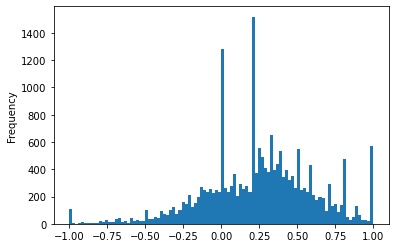

In [54]:
# Polarity is normally distributed around 0.25 (1 = very positive, and -1 = very negative)

reviews_df['polarity_before_clean'].plot(kind = 'hist', bins = 100);

# Cleaning

In [55]:
# Create a copy 

reviews_prep = reviews_df.copy()

In [56]:
# Convert all reviews to lowercase

reviews_prep['lower'] = reviews_prep['review'].apply(lambda x: " ".join(x.lower() for x in x.split()))
reviews_prep['lower'].head()

0    cristy was amazing i spoke with cristy and she...
1    unhappy customer i placed an order at the end ...
2    still waiting placed an order 3rd december and...
3    great after sales support great after sales su...
4    michael was very polite and helpful… michael w...
Name: lower, dtype: object

In [57]:
# Remove punctuation

reviews_prep['no_punc'] = reviews_prep['lower'].str.replace('[^\w\s]','')
reviews_prep['no_punc'].head()

0    cristy was amazing i spoke with cristy and she...
1    unhappy customer i placed an order at the end ...
2    still waiting placed an order 3rd december and...
3    great after sales support great after sales su...
4    michael was very polite and helpful michael wa...
Name: no_punc, dtype: object

In [58]:
# Remove stopwords

stop = stopwords.words('english')
reviews_prep['no_stop'] = reviews_prep['no_punc'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
reviews_prep['no_stop'].head()

0    cristy amazing spoke cristy brilliant although...
1    unhappy customer placed order end november bla...
2    still waiting placed order 3rd december still ...
3        great sales support great sales support thank
4    michael polite helpful michael polite helpful ...
Name: no_stop, dtype: object

In [59]:
# Remove numbers 

reviews_prep['no_num'] = reviews_prep['no_stop'].str.replace('\d+', '')
reviews_prep['no_num'].head()

0    cristy amazing spoke cristy brilliant although...
1    unhappy customer placed order end november bla...
2    still waiting placed order rd december still w...
3        great sales support great sales support thank
4    michael polite helpful michael polite helpful ...
Name: no_num, dtype: object

In [60]:
# Review the most common words

pd.Series(' '.join(reviews_prep['no_num']).split()).value_counts()[:10]

service     11786
customer    11132
asos         9871
helpful      7547
order        5853
great        4661
refund       3919
delivery     3451
issue        3280
help         2923
dtype: int64

In [61]:
# Wordclouds

text = " ".join(review for review in reviews_prep['no_num'])
print ("There are {} words in the combination of all reviews.".format(len(text)))

There are 3174901 words in the combination of all reviews.


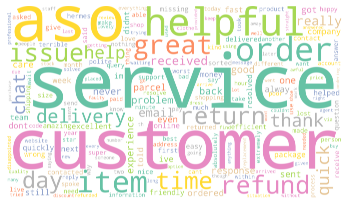

In [62]:
# Generate wordCloud

wordcloud = WordCloud(width = 7000, height = 4000, random_state = 1, 
                      background_color = 'white', colormap = 'Set2', collocations = False, 
                      min_font_size = 10).generate(text)

# Display the image 

plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.show()

In [63]:
# Create a list of additional words that do not add meaning to the analysis

additional_stopwords = ['asos', 'order', 'item', 'customer', 'service', 'items', 'day', 'orders']

In [64]:
# Remove additional stopwords

reviews_prep['words_removed'] = reviews_prep['no_num'].apply(lambda x: " ".join(x for x in x.split() if x not in additional_stopwords))
reviews_prep['words_removed'].head()

0    cristy amazing spoke cristy brilliant although...
1    unhappy placed end november black friday disco...
2    still waiting placed rd december still waiting...
3        great sales support great sales support thank
4    michael polite helpful michael polite helpful ...
Name: words_removed, dtype: object

In [65]:
text_1 = " ".join(review for review in reviews_prep['words_removed'])
print ("There are {} words in the combination of all reviews.".format(len(text_1)))

There are 2846205 words in the combination of all reviews.


In [66]:
# Create two data frames for 'positive' and 'negative' words

pos_df = reviews_prep[reviews_prep['stars'] == '5']
neg_df = reviews_prep[reviews_prep['stars'] == '1']

In [67]:
pos_words = " ".join(review for review in pos_df['words_removed'])
neg_words = " ".join(review for review in neg_df['words_removed'])


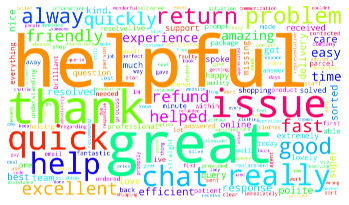

In [68]:
# Generate wordCloud

wordcloud = WordCloud(width = 7000, height = 4000, random_state = 1, 
                      background_color = 'white', colormap = 'hsv', collocations = False, 
                      min_font_size = 10).generate(pos_words)

# Display the image 

plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.show()

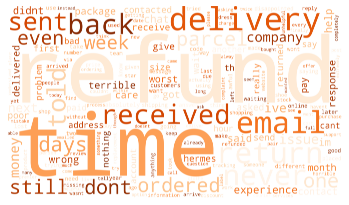

In [69]:
# Generate wordCloud

wordcloud = WordCloud(width = 7000, height = 4000, random_state = 1, 
                      background_color = 'white', colormap = 'Oranges', collocations = False, 
                      min_font_size = 10).generate(neg_words)

# Display the image 

plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.show()

# Preprocessing

In [70]:
# Tokenization

# Create Tokenizer

tokenizer = RegexpTokenizer(r'\w+')

In [71]:
reviews_prep['token'] = reviews_prep['words_removed'].apply(lambda x: tokenizer.tokenize(x.lower()))
reviews_prep['token'].head(5)


0    [cristy, amazing, spoke, cristy, brilliant, al...
1    [unhappy, placed, end, november, black, friday...
2    [still, waiting, placed, rd, december, still, ...
3    [great, sales, support, great, sales, support,...
4    [michael, polite, helpful, michael, polite, he...
Name: token, dtype: object

In [72]:
# Add speech tags

reviews_prep['pos_tags'] = reviews_prep['token'].apply(nltk.tag.pos_tag)
reviews_prep['pos_tags'].head()

0    [(cristy, JJ), (amazing, VBG), (spoke, NN), (c...
1    [(unhappy, JJ), (placed, VBD), (end, JJ), (nov...
2    [(still, RB), (waiting, VBG), (placed, VBN), (...
3    [(great, JJ), (sales, NNS), (support, NN), (gr...
4    [(michael, NN), (polite, VBP), (helpful, JJ), ...
Name: pos_tags, dtype: object

In [73]:
# Define function to convert parts of speech tags to wordnet’s format

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [74]:
# Apply the function to the tagged data

reviews_prep['lemmatized'] = reviews_prep['pos_tags'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])
reviews_prep['lemmatized'].head()

0    [(cristy, a), (amazing, v), (spoke, n), (crist...
1    [(unhappy, a), (placed, v), (end, a), (novembe...
2    [(still, r), (waiting, v), (placed, v), (rd, n...
3    [(great, a), (sales, n), (support, n), (great,...
4    [(michael, n), (polite, v), (helpful, a), (mic...
Name: lemmatized, dtype: object

In [75]:
# Create lemmatizer

lemmatizer = WordNetLemmatizer()

# Apply to data 

reviews_prep['lemmatized'] = reviews_prep['lemmatized'].apply(lambda x: [lemmatizer.lemmatize(word, tag) for word, tag in x])
reviews_prep.head(3)

,date,review,stars,length,polarity_before_clean,lower,no_punc,no_stop,no_num,words_removed,token,pos_tags,lemmatized
0,2020-12-09,Cristy was amazing ...,5,225,0.580208,cristy was amazing i spoke with cristy and she...,cristy was amazing i spoke with cristy and she...,cristy amazing spoke cristy brilliant although...,cristy amazing spoke cristy brilliant although...,cristy amazing spoke cristy brilliant although...,"[cristy, amazing, spoke, cristy, brilliant, al...","[(cristy, JJ), (amazing, VBG), (spoke, NN), (c...","[cristy, amaze, spoke, cristy, brilliant, alth..."
1,2020-12-09,Unhappy customer ...,1,1694,-0.061012,unhappy customer i placed an order at the end ...,unhappy customer i placed an order at the end ...,unhappy customer placed order end november bla...,unhappy customer placed order end november bla...,unhappy placed end november black friday disco...,"[unhappy, placed, end, november, black, friday...","[(unhappy, JJ), (placed, VBD), (end, JJ), (nov...","[unhappy, place, end, november, black, friday,..."
2,2020-12-09,Still Waiting P...,2,145,-0.195000,still waiting placed an order 3rd december and...,still waiting placed an order 3rd december and...,still waiting placed order 3rd december still ...,still waiting placed order rd december still w...,still waiting placed rd december still waiting...,"[still, waiting, placed, rd, december, still, ...","[(still, RB), (waiting, VBG), (placed, VBN), (...","[still, wait, place, rd, december, still, wait..."


In [76]:
reviews_prep['joined'] = reviews_prep['lemmatized'].apply(lambda x: ' '.join(x))

In [77]:
reviews_prep['polarity_after_clean'] = reviews_prep['joined'].apply(lambda x: TextBlob(x).sentiment.polarity)


In [78]:
reviews_prep.to_csv('asos_reviews_clean_date.csv')